## Awkward arrays: jaggedness and more

In [04-ttree-data-pyroot.ipynb](04-ttree-data-pyroot.ipynb), we saw some examples of jagged and object data. Uproot uses a package called "awkward" to deal with them.

This section focuses on various kinds of awkward arrays and what you can do with them (including making them less awkward: into pure Numpy arrays!).

Everything that comes out of uproot is a Numpy array, a `JaggedArray`, a `Table`, an `ObjectArray`, or some combination.

In [1]:
import uproot
a = uproot.open("http://scikit-hep.org/uproot/examples/HZZ.root")["events"].array("Muon_Px")
a

<JaggedArray [[-52.89945602416992 37.7377815246582] [-0.8164593577384949] [48.987831115722656 0.8275666832923889] ... [-29.756786346435547] [1.1418697834014893] [23.913206100463867]] at 0x7f7d8788db38>

In [2]:
type(a)

awkward.array.jagged.JaggedArray

In [3]:
type(a.content)

numpy.ndarray

In [4]:
b = uproot.open("http://scikit-hep.org/uproot/examples/HZZ-objects.root")["events"].array("muonp4")
b

<JaggedArrayMethods [[TLorentzVector(-52.899, -11.655, -8.1608, 54.779) TLorentzVector(37.738, 0.69347, -11.308, 39.402)] [TLorentzVector(-0.81646, -24.404, 20.2, 31.69)] [TLorentzVector(48.988, -21.723, 11.168, 54.74) TLorentzVector(0.82757, 29.801, 36.965, 47.489)] ... [TLorentzVector(-29.757, -15.304, -52.664, 62.395)] [TLorentzVector(1.1419, 63.61, 162.18, 174.21)] [TLorentzVector(23.913, -35.665, 54.719, 69.556)]] at 0x7f7d86598a20>

In [5]:
type(b)

awkward.array.objects.JaggedArrayMethods

In [6]:
type(b.content)

awkward.array.objects.ObjectArrayMethods

In [7]:
type(b.content.content)

awkward.array.table.Table

In [8]:
type(b.content.content.contents["fX"])

numpy.ndarray

If ROOT managed to "split" the objects into columns, then the data are in a columnar state: each attribute represented by a contiguous array.

In [9]:
b.content.content.contents["fX"]

array([-52.89945602,  37.73778152,  -0.81645936, ..., -29.75678635,
         1.14186978,  23.9132061 ])

In [10]:
b.content.content.contents["fY"]

array([-11.65467167,   0.69347358, -24.40425873, ..., -15.30385876,
        63.60956955, -35.66507721])

Even if the data are "unsplit," they're presented as a bag of bytes and a Python function to interpret them, as an `ObjectArray`.

In [11]:
c = uproot.open("http://scikit-hep.org/uproot/examples/Event.root")["T"].array("fH")
c

<ObjectArray [<b'TH1F' b'hstat' 0x7f7d8446c188> <b'TH1F' b'hstat' 0x7f7d8446c4a8> <b'TH1F' b'hstat' 0x7f7d84489b38> ... <b'TH1F' b'hstat' 0x7f7d8656c138> <b'TH1F' b'hstat' 0x7f7d8781b1d8> <b'TH1F' b'hstat' 0x7f7d84489318>] at 0x7f7d84504320>

In [12]:
c.content     # bags of bytes, for each entry

<JaggedArray [[64 0 3 ... 0 0 0] [64 0 3 ... 0 0 0] [64 0 3 ... 0 0 0] ... [64 0 3 ... 0 0 0] [64 0 3 ... 0 0 0] [64 0 3 ... 0 0 0]] at 0x7f7d845040b8>

In [13]:
c.generator   # interpretation class

TH1F

In [14]:
c[500].show()

                0                                                           12.6
                +--------------------------------------------------------------+
[-inf, 0)    0  |                                                              |
[0, 0.01)    10 |*************************************************             |
[0.01, 0.02) 12 |***********************************************************   |
[0.02, 0.03) 5  |*************************                                     |
[0.03, 0.04) 6  |******************************                                |
[0.04, 0.05) 5  |*************************                                     |
[0.05, 0.06) 8  |***************************************                       |
[0.06, 0.07) 7  |**********************************                            |
[0.07, 0.08) 5  |*************************                                     |
[0.08, 0.09) 4  |********************                                          |
[0.09, 0.1)  2  |********** 

A `JaggedArray` is a list of unequal-sized sublists, encoded as a continuous array of `content` divided up by an array of `offsets`.

In [15]:
import awkward
x = awkward.fromiter([[1.1, 2.2, 3.3], [], [4.4, 5.5]])
x

<JaggedArray [[1.1 2.2 3.3] [] [4.4 5.5]] at 0x7f7d84477f28>

In [16]:
x.content

array([1.1, 2.2, 3.3, 4.4, 5.5])

In [17]:
x.offsets

array([0, 3, 3, 5])

A `Table` is an array of `Row` records, encoded as a continuous array of each column in its `contents` dict.

In [18]:
x = awkward.fromiter([{"x": 1, "y": 1.1}, {"x": 2, "y": 2.2}, {"x": 3, "y": 3.3}])
x

<Table [<Row 0> <Row 1> <Row 2>] at 0x7f7d84477358>

In [19]:
x.tolist()

[{'x': 1, 'y': 1.1}, {'x': 2, 'y': 2.2}, {'x': 3, 'y': 3.3}]

In [20]:
x.contents["x"]

array([1, 2, 3])

In [21]:
x.contents["y"]

array([1.1, 2.2, 3.3])

An `ObjectArray` is a virtual array of objects, represented by some array `content` and a `generator` that creates each object on demand.

In [22]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __repr__(self):
        return "Point({0}, {1})".format(self.x, self.y)

x = awkward.fromiter([Point(1, 1.1), Point(2, 2.2), Point(3, 3.3)])
x

<ObjectArray [Point(1, 1.1) Point(2, 2.2) Point(3, 3.3)] at 0x7f7d844771d0>

In [23]:
x.content

<Table [<Row 0> <Row 1> <Row 2>] at 0x7f7d84512940>

In [24]:
x.content.contents["x"]

array([1, 2, 3])

In [25]:
x.content.contents["y"]

array([1.1, 2.2, 3.3])

## Jagged operations

As much as possible, awkward arrays act like Numpy arrays.

In [26]:
x = awkward.fromiter([[1.1, 2.2, 3.3, 4.4], [5.5, 6.6], [7.7, 8.8, 9.9]])
x

<JaggedArray [[1.1 2.2 3.3 4.4] [5.5 6.6] [7.7 8.8 9.9]] at 0x7f7d84512c18>

In [27]:
# take the first two inner lists
x[:2]

<JaggedArray [[1.1 2.2 3.3 4.4] [5.5 6.6]] at 0x7f7d845120b8>

In [28]:
# take the first two numbers in each inner list
x[:, :2]

<JaggedArray [[1.1 2.2] [5.5 6.6] [7.7 8.8]] at 0x7f7d84512048>

In [29]:
# mask outer lists
x[[True, False, True]]

<JaggedArray [[1.1 2.2 3.3 4.4] [7.7 8.8 9.9]] at 0x7f7d84468240>

In [30]:
# mask inner lists
x[awkward.fromiter([[True, False, True, False], [False, True], [True, True, False]])]

<JaggedArray [[1.1 3.3] [6.6] [7.7 8.8]] at 0x7f7d84468470>

Reductions (min, max, sum, ...) turn Numpy arrays into scalars and jagged arrays into flat Numpy arrays.

In [31]:
x

<JaggedArray [[1.1 2.2 3.3 4.4] [5.5 6.6] [7.7 8.8 9.9]] at 0x7f7d84512c18>

In [32]:
x.min()

array([1.1, 5.5, 7.7])

In [33]:
x.max()

array([4.4, 6.6, 9.9])

Empty sublists return the identity of the reduction operation's group. (Group theory "group.")

In [34]:
x = awkward.fromiter([[1.1, 2.2, 3.3], [], [4.4, 5.5]])
x

<JaggedArray [[1.1 2.2 3.3] [] [4.4 5.5]] at 0x7f7d845127f0>

In [35]:
x.sum()

array([6.6, 0. , 9.9])

In [36]:
x.max()    # what's the identity of max? of min?

array([ 3.3, -inf,  5.5])

There's also an equivalent of `argmin/argmax` that returns jagged arrays of indexes.

In [37]:
x = awkward.fromiter([[1.1, 2.2, 3.3], [], [4.4, 5.5]])
x

<JaggedArray [[1.1 2.2 3.3] [] [4.4 5.5]] at 0x7f7d84477ef0>

In [38]:
indexes = x.argmax()
indexes

<JaggedArray [[2] [] [1]] at 0x7f7d8658ac88>

What's this useful for? Maximizing by one attribute and applying to another.

In [39]:
y = awkward.fromiter([[300, 200, 100], [], [500, 400]])
y

<JaggedArray [[300 200 100] [] [500 400]] at 0x7f7d845040f0>

In [40]:
y[indexes]

<JaggedArray [[100] [] [400]] at 0x7f7d84504ac8>

In Numpy, selecting elements by an array of indexes is called "fancy indexing."

Numpy's "universal functions" can be applied to awkward arrays. They apply element-by-element and maintain structure.

In [41]:
x

<JaggedArray [[1.1 2.2 3.3] [] [4.4 5.5]] at 0x7f7d84477ef0>

In [42]:
import numpy
numpy.sqrt(x)

<JaggedArray [[1.0488088481701516 1.4832396974191326 1.816590212458495] [] [2.0976176963403033 2.345207879911715]] at 0x7f7d84504d30>

This allows us to compute things with awkward arrays as we would Numpy arrays—as long as the structure matches.

In [43]:
x + y**2

<JaggedArray [[90001.1 40002.2 10003.3] [] [250004.4 160005.5]] at 0x7f7d84504470>

This is how all Lorentz vector methods are implemented: array-by-array operations.

In [44]:
b    # a JaggedArray of TLorentzVector objects that also has TLorentzVector methods

<JaggedArrayMethods [[TLorentzVector(-52.899, -11.655, -8.1608, 54.779) TLorentzVector(37.738, 0.69347, -11.308, 39.402)] [TLorentzVector(-0.81646, -24.404, 20.2, 31.69)] [TLorentzVector(48.988, -21.723, 11.168, 54.74) TLorentzVector(0.82757, 29.801, 36.965, 47.489)] ... [TLorentzVector(-29.757, -15.304, -52.664, 62.395)] [TLorentzVector(1.1419, 63.61, 162.18, 174.21)] [TLorentzVector(23.913, -35.665, 54.719, 69.556)]] at 0x7f7d86598a20>

In [45]:
b.pt

<JaggedArray [[54.16810703140204 37.74415265978988] [24.41791248135961] [53.58826697278532 29.811997139120674] ... [33.461536523629654] [63.619817705512375] [42.93994828083644]] at 0x7f7d84553358>

The `.pt` is a property implemented as

In [46]:
numpy.sqrt(b["fX"]**2 + b["fY"]**2)

<JaggedArray [[54.16810703140204 37.74415265978988] [24.41791248135961] [53.58826697278532 29.811997139120674] ... [33.461536523629654] [63.619817705512375] [42.93994828083644]] at 0x7f7d84553f28>

**Physics case:** add the first and second muon of each event to get Z masses.

In [47]:
first = b[:, 0]
second = b[:, 0]

IndexError: index 0 is out of bounds for jagged min size 0

In [48]:
hastwo = (b.counts >= 2)
hastwo

array([ True, False,  True, ..., False, False, False])

In [49]:
first = b[hastwo, 0]
second = b[hastwo, 1]
first                    # an ObjectArray with TLorentzVector methods, but no longer jagged

<ObjectArrayMethods [TLorentzVector(-52.899, -11.655, -8.1608, 54.779) TLorentzVector(48.988, -21.723, 11.168, 54.74) TLorentzVector(22.088, -85.835, 403.85, 413.46) ... TLorentzVector(53.006, -24.486, 13.952, 60.032) TLorentzVector(55.72, 26.37, -24.588, 66.368) TLorentzVector(34.507, 28.84, -150.66, 157.23)] at 0x7f7d84504860>

In [50]:
(first + second).mass

array([90.22779777, 74.74654928, 89.75736376, ..., 92.06495256,
       85.44384208, 75.96066262])

In [51]:
%matplotlib inline

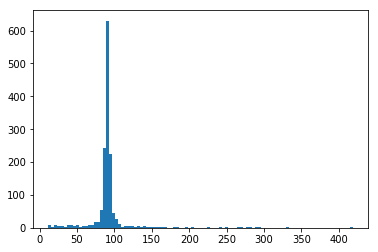

In [52]:
import matplotlib.pyplot
matplotlib.pyplot.hist((first + second).mass, 100);

As more analysis groups use awkward arrays, we add more functions for dealing with complex cases.

In [53]:
x = awkward.fromiter([[1.1, 2.2, 3.3, 4.4, 5.5], [], [6.6, 7.7, 8.8]])
x

<JaggedArray [[1.1 2.2 3.3 4.4 5.5] [] [6.6 7.7 8.8]] at 0x7f7d480d5eb8>

In [54]:
x.pad(4)                                     # ensure at least two elements

<JaggedArray [[1.1 2.2 3.3 4.4 5.5] [None None None None] [6.6 7.7 8.8 None]] at 0x7f7d4812dd68>

In [55]:
x.pad(4, clip=True)                          # exactly two elements

<JaggedArray [[1.1 2.2 3.3 4.4] [None None None None] [6.6 7.7 8.8 None]] at 0x7f7d4816a390>

In [56]:
x.pad(4, clip=True).fillna(-1000)            # turn "None" into -1000

<JaggedArray [[1.1 2.2 3.3 4.4] [-1000.0 -1000.0 -1000.0 -1000.0] [6.6 7.7 8.8 -1000.0]] at 0x7f7d84504518>

In [57]:
x.pad(4, clip=True).fillna(-1000).regular()  # and make it a plain 'ol Numpy array

array([[    1.1,     2.2,     3.3,     4.4],
       [-1000. , -1000. , -1000. , -1000. ],
       [    6.6,     7.7,     8.8, -1000. ]])

In [58]:
x

<JaggedArray [[1.1 2.2 3.3 4.4 5.5] [] [6.6 7.7 8.8]] at 0x7f7d480d5eb8>

In [59]:
y = awkward.fromiter([[100, 200], [300], [400, 500]])
y

<JaggedArray [[100 200] [300] [400 500]] at 0x7f7d480842b0>

In [60]:
awkward.JaggedArray.concatenate([x, y])

<JaggedArray [[1.1 2.2 3.3 4.4 5.5] [] [6.6 7.7 8.8] [100.0 200.0] [300.0] [400.0 500.0]] at 0x7f7d48084390>

In [61]:
awkward.JaggedArray.concatenate([x, y], axis=1)

<JaggedArray [[1.1 2.2 3.3 ... 5.5 100.0 200.0] [300.0] [6.6 7.7 8.8 400.0 500.0]] at 0x7f7d480f31d0>

Combinatorics: emulating nested "for" loops.

In [62]:
x = awkward.fromiter([[1.1, 2.2, 3.3], [], [4.4, 5.5]])
y = awkward.fromiter([[10, 20], [30], [40]])

In [63]:
z = x.cross(y)
z

<JaggedArray [[(1.1, 10) (1.1, 20) (2.2, 10) (2.2, 20) (3.3, 10) (3.3, 20)] [] [(4.4, 40) (5.5, 40)]] at 0x7f7d48084c88>

In [64]:
z.i0

<JaggedArray [[1.1 1.1 2.2 2.2 3.3 3.3] [] [4.4 5.5]] at 0x7f7d48084fd0>

In [65]:
z.i1

<JaggedArray [[10 20 10 20 10 20] [] [40 40]] at 0x7f7d4809a358>

Using combinatorics to do the Z peak better: use all muons, not just the first two.

In [66]:
b

<JaggedArrayMethods [[TLorentzVector(-52.899, -11.655, -8.1608, 54.779) TLorentzVector(37.738, 0.69347, -11.308, 39.402)] [TLorentzVector(-0.81646, -24.404, 20.2, 31.69)] [TLorentzVector(48.988, -21.723, 11.168, 54.74) TLorentzVector(0.82757, 29.801, 36.965, 47.489)] ... [TLorentzVector(-29.757, -15.304, -52.664, 62.395)] [TLorentzVector(1.1419, 63.61, 162.18, 174.21)] [TLorentzVector(23.913, -35.665, 54.719, 69.556)]] at 0x7f7d86598a20>

In [67]:
pairs = b.cross(b)
(pairs.i0 + pairs.i1).mass

/home/pivarski/miniconda3/lib/python3.7/site-packages/uproot_methods-0.4.5-py3.7.egg/uproot_methods/classes/TLorentzVector.py:206: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))


<JaggedArray [[0.2111859748287381 90.22779776988638 90.22779776988638 0.21090494082084574] [0.210998480800626] [0.21392618221202328 74.74654928040661 74.74654928040661 0.2102757625673823] ... [0.2108764933349408] [0.1950119912345726] [0.20894448339535043]] at 0x7f7d4809ada0>

Why are some masses `2*0.106`?

Because it's the mass of a muon four-vector with itself...

Now without double-counting.

In [68]:
pairs = b.distincts()   # like b.cross(b), but taking only pairs above the diagonal
pairs

<JaggedArray [[(TLorentzVector(-52.899, -11.655, -8.1608, 54.779), TLorentzVector(37.738, 0.69347, -11.308, 39.402))] [] [(TLorentzVector(48.988, -21.723, 11.168, 54.74), TLorentzVector(0.82757, 29.801, 36.965, 47.489))] ... [] [] []] at 0x7f7d48084160>

In [69]:
(pairs.i0 + pairs.i1).mass

<JaggedArray [[90.22779776988638] [] [74.74654928040661] ... [] [] []] at 0x7f7d480f30f0>

More involved example from a CMS analysis: jet cleaning.

In [70]:
dataset = uproot.open("http://scikit-hep.org/uproot/examples/HZZ-objects.root")["events"]
muons = dataset.array("muonp4")
jets = dataset.array("jetp4")

In [71]:
def ΔR(combinations):
    return combinations.i0.delta_r(combinations.i1)

combinations = jets.cross(muons, nested=True)     # nested=True means make a doubly jagged array; "any()" reduces one level
jets[~(ΔR(combinations) < 0.5).any()]             # "jets for which not (~) any combination has ΔR < 0.5"

<JaggedArrayMethods [[] [TLorentzVector(-38.875, 19.863, -0.89494, 44.137)] [] ... [TLorentzVector(-3.7148, -37.202, 41.012, 55.951)] [TLorentzVector(-36.361, 10.174, 226.43, 229.58) TLorentzVector(-15.257, -27.175, 12.12, 33.92)] []] at 0x7f7d287da898>

Numpy has a concept of "broadcasting," in which an array and a scalar may be operated element-by-element, by duplicating the scalar to match the array.

In [72]:
numpy.array([1.1, 2.2, 3.3, 4.4, 5.5]) + 100

array([101.1, 102.2, 103.3, 104.4, 105.5])

The jagged equivalent of this is broadcasting a Numpy array to match a jagged array:

In [73]:
x

<JaggedArray [[1.1 2.2 3.3] [] [4.4 5.5]] at 0x7f7d48084d30>

In [74]:
x + numpy.array([100, 200, 300])

<JaggedArray [[101.1 102.2 103.3] [] [304.4 305.5]] at 0x7f7d287bfa20>

**Physics case:** consider a jagged array of timing measurements.

In [75]:
times = awkward.fromiter([[4.4, 2.6, 3.5, -0.6], [1.8, 7.4], [], [9.5, 5.2, 8.5]])   # in picoseconds, probably
times

<JaggedArray [[4.4 2.6 3.5 -0.6] [1.8 7.4] [] [9.5 5.2 8.5]] at 0x7f7d287bfc88>

Time-zero corrections (`t0`) may be applied globally:

In [76]:
times - 0.6

<JaggedArray [[3.8000000000000003 2.0 2.9 -1.2] [1.2000000000000002 6.800000000000001] [] [8.9 4.6000000000000005 7.9]] at 0x7f7d287bf1d0>

Or they may be applied per event:

In [77]:
times - numpy.array([0.6, 1.2, -0.4, 3.3])

<JaggedArray [[3.8000000000000003 2.0 2.9 -1.2] [0.6000000000000001 6.2] [] [6.2 1.9000000000000004 5.2]] at 0x7f7d287bf198>

Or by detector id:

In [78]:
times

<JaggedArray [[4.4 2.6 3.5 -0.6] [1.8 7.4] [] [9.5 5.2 8.5]] at 0x7f7d287bfc88>

In [79]:
detid = awkward.fromiter([[101, 274, 101, 97], [274, 97], [], [101, 634, 274]])
detid

<JaggedArray [[101 274 101 97] [274 97] [] [101 634 274]] at 0x7f7d287cd278>

In [80]:
lookup = awkward.SparseArray(1000, [97, 101, 274, 634], [0.1, 0.2, 0.3, 0.4])  # 97 → 0.1, 101 → 0.2, 274 → 0.3, 634 → 0.4
lookup

<SparseArray [0.0 0.0 0.0 ... 0.0 0.0 0.0] at 0x7f7d287cd8d0>

In [81]:
corrections = awkward.JaggedArray.fromoffsets(detid.offsets, lookup[detid.content])
corrections

<JaggedArray [[0.2 0.3 0.2 0.1] [0.3 0.1] [] [0.2 0.4 0.3]] at 0x7f7d287cde10>

In [82]:
times - corrections

<JaggedArray [[4.2 2.3000000000000003 3.3 -0.7] [1.5 7.300000000000001] [] [9.3 4.8 8.2]] at 0x7f7d287bfeb8>

## Other awkward types

The last example used a `SparseArray`, which I haven't explained yet. The awkward library has quite a few array classes, all mutually composable:

In [83]:
[x for x in dir(awkward) if "Array" in x]

['AppendableArray',
 'BitMaskedArray',
 'ChunkedArray',
 'IndexedArray',
 'IndexedMaskedArray',
 'JaggedArray',
 'MaskedArray',
 'ObjectArray',
 'SparseArray',
 'StringArray',
 'UnionArray',
 'VirtualArray']

<table style="font-size: 22pt; margin-top: 50px">
    <tr style="font-weight: bold"><td>Array type</td><td>Purpose</td><td>Members</td><td>Usage</td></tr>
    <tr><td>JaggedArray</td><td>variable-sized data structures</td><td>starts, stops, content</td><td>ubiquitous</td></tr>
    <tr><td>Table</td><td>struct-like objects in columns</td><td>contents (dict)</td><td>ubiquitous</td></tr>
    <tr><td>ObjectArray</td><td>arbitrary Python types on demand</td><td>generator, content</td><td>common</td></tr>
    <tr><td>Methods</td><td>mix-in methods and properties on any array type</td><td>(none)</td><td>common</td></tr>
    <tr><td>MaskedArray</td><td>allow nullable values (None)</td><td>mask (bytes), content</td><td>occasional</td></tr>
    <tr><td>BitMaskedArray</td><td>same, but with a bit-mask</td><td>mask (bits), content</td><td>from Arrow</td></tr>
    <tr><td>IndexedMaskedArray</td><td>same, but with dense content</td><td>mask-index (integers) content</td><td>rare</td></tr>
    <tr><td>IndexedArray</td><td>lazy fancy indexing: "pointers"</td><td>index, content</td><td>rare</td></tr>
    <tr><td>SparseArray</td><td>huge array defined at a few indexes</td><td>index, content, default</td><td>rare</td></tr>
    <tr><td>UnionArray</td><td>heterogeneous types or data sources</td><td>tags, index, contents (list)</td><td>rare</td></tr>
    <tr><td>StringArray</td><td>special case: jagged array of char</td><td>starts, stops, content, string methods</td><td>common</td></tr>
    <tr><td>ChunkedArray</td><td>discontiguous array presented as a whole</td><td>counts, chunks (lists)</td><td>from Parquet</td></tr>
    <tr><td>AppendableArray</td><td>chunked allocation for efficient appending</td><td>counts, chunks (lists)</td><td>rare</td></tr>
    <tr><td>VirtualArray</td><td>array generated from a function when needed</td><td>generator, possible cached array</td><td>from Parquet</td></tr>
</table>

Taken together, this allows for some complex data structures, all backed by arrays.

In [84]:
array = awkward.fromiter([[1.1, 2.2, None, 3.3, None],
                          [4.4, [5.5]],
                          [{"x": 6, "y": {"z": 7}}, None, {"x": 8, "y": {"z": 9}}]
                         ])
array

<JaggedArray [[1.1 2.2 None 3.3 None] [4.4 [5.5]] [<Row 0> None <Row 1>]] at 0x7f7d287ec6a0>

In [85]:
print(array.type)

[0, 3) -> [0, inf) -> ?((float64             |
                         [0, inf) -> float64 |
                         'x' -> int64
                         'y' -> 'z' -> int64 ))


"An array of 3 elements, containing arrays of any number of elements, containing nullable (`?`) data that may be `float64`, jagged arrays of `float64`, or records with fields `"x"` (`int64`) and `"y"` (records with single field `"z"` (`int64`))."

All the same broadcasting and slicing rules apply. They are complex data structures with Numpy idioms.

In [86]:
array.tolist()

[[1.1, 2.2, None, 3.3, None],
 [4.4, [5.5]],
 [{'x': 6, 'y': {'z': 7}}, None, {'x': 8, 'y': {'z': 9}}]]

In [87]:
(array + 100).tolist()

[[101.1, 102.2, None, 103.3, None],
 [104.4, [105.5]],
 [{'x': 106, 'y': {'z': 107}}, None, {'x': 108, 'y': {'z': 109}}]]

In [88]:
array[:, -2:].tolist()

[[3.3, None], [4.4, [5.5]], [None, {'x': 8, 'y': {'z': 9}}]]

In [89]:
# get Higgs → ZZ events
tree = uproot.open("http://scikit-hep.org/uproot/examples/HZZ.root")["events"]

# make a Table of MET (missing energy, one per event)
events = awkward.Table(tree.arrays(["MET_px", "MET_py"], namedecode="utf-8"))

# add a jagged table (JaggedArray of Table) so muons share a single "offsets"
events["muons"] = awkward.JaggedArray.zip(tree.arrays(["Muon_Px", "Muon_Py", "Muon_Pz"], namedecode="utf-8"))

# add a jagged table of jets in the same way
events["jets"] = awkward.JaggedArray.zip(tree.arrays(["Jet_Px", "Jet_Py", "Jet_Pz"], namedecode="utf-8"))

# here they are
events

<Table [<Row 0> <Row 1> <Row 2> ... <Row 2418> <Row 2419> <Row 2420>] at 0x7f7d48044d68>

In [90]:
print(events.type)

[0, 2421) -> 'MET_px' -> float32
             'MET_py' -> float32
             'muons'  -> [0, inf) -> 'Muon_Px' -> float32
                                     'Muon_Py' -> float32
                                     'Muon_Pz' -> float32
             'jets'   -> [0, inf) -> 'Jet_Px' -> float32
                                     'Jet_Py' -> float32
                                     'Jet_Pz' -> float32


In [91]:
events[0].tolist()

{'MET_px': 5.912771224975586,
 'MET_py': 2.5636332035064697,
 'muons': [{'Muon_Px': -52.89945602416992,
   'Muon_Py': -11.654671669006348,
   'Muon_Pz': -8.16079330444336},
  {'Muon_Px': 37.7377815246582,
   'Muon_Py': 0.6934735774993896,
   'Muon_Pz': -11.307581901550293}],
 'jets': []}

In [92]:
events[3].tolist()

{'MET_px': 8.619895935058594,
 'MET_py': -22.78654670715332,
 'muons': [{'Muon_Px': 22.08833122253418,
   'Muon_Py': -85.83546447753906,
   'Muon_Pz': 403.84844970703125},
  {'Muon_Px': 76.6919174194336,
   'Muon_Py': -13.956494331359863,
   'Muon_Pz': 335.0942077636719}],
 'jets': [{'Jet_Px': -71.6952133178711,
   'Jet_Py': 93.57157897949219,
   'Jet_Pz': 196.2964324951172},
  {'Jet_Px': 36.60636901855469,
   'Jet_Py': 21.83879280090332,
   'Jet_Pz': 91.6662826538086},
  {'Jet_Px': -28.866418838500977,
   'Jet_Py': 9.320708274841309,
   'Jet_Pz': 51.243221282958984}]}

## Persistence

These data structures can be saved and restored from disk in a variety of formats. (Not yet for ROOT, but that's planned for this summer.)

In [99]:
!rm tmp.awkd

In [100]:
awkward.save("tmp.awkd", events)             # this is just like numpy.save

In [101]:
awkward.load("tmp.awkd")[3].tolist()         # and numpy.load

{'MET_px': 8.619895935058594,
 'MET_py': -22.78654670715332,
 'muons': [{'Muon_Px': 22.08833122253418,
   'Muon_Py': -85.83546447753906,
   'Muon_Pz': 403.84844970703125},
  {'Muon_Px': 76.6919174194336,
   'Muon_Py': -13.956494331359863,
   'Muon_Pz': 335.0942077636719}],
 'jets': [{'Jet_Px': -71.6952133178711,
   'Jet_Py': 93.57157897949219,
   'Jet_Pz': 196.2964324951172},
  {'Jet_Px': 36.60636901855469,
   'Jet_Py': 21.83879280090332,
   'Jet_Pz': 91.6662826538086},
  {'Jet_Px': -28.866418838500977,
   'Jet_Py': 9.320708274841309,
   'Jet_Pz': 51.243221282958984}]}

In [102]:
!rm tmp.hdf5

In [103]:
import h5py
file = awkward.hdf5(h5py.File("tmp.hdf5"))   # wrap HDF5 file as an awkward HDF5 file
file

<awkward.hdf5 '/' (0 members)>

In [104]:
file["events"] = events                      # translates awkward structures into groups of flat arrays

In [105]:
file["events"][3].tolist()                   # and translates back

{'MET_px': 8.619895935058594,
 'MET_py': -22.78654670715332,
 'muons': [{'Muon_Px': 22.08833122253418,
   'Muon_Py': -85.83546447753906,
   'Muon_Pz': 403.84844970703125},
  {'Muon_Px': 76.6919174194336,
   'Muon_Py': -13.956494331359863,
   'Muon_Pz': 335.0942077636719}],
 'jets': [{'Jet_Px': -71.6952133178711,
   'Jet_Py': 93.57157897949219,
   'Jet_Pz': 196.2964324951172},
  {'Jet_Px': 36.60636901855469,
   'Jet_Py': 21.83879280090332,
   'Jet_Pz': 91.6662826538086},
  {'Jet_Px': -28.866418838500977,
   'Jet_Py': 9.320708274841309,
   'Jet_Pz': 51.243221282958984}]}

Parquet is a format for columnar data, currently limited to jagged arrays, not jagged tables.

In [106]:
tree = uproot.open("http://scikit-hep.org/uproot/examples/HZZ.root")["events"]
events = awkward.Table(tree.arrays(["MET_px", "MET_py", "Muon_Px", "Muon_Py", "Muon_Pz"], namedecode="utf-8"))
print(events.type)

[0, 2421) -> 'MET_px'  -> float32
             'MET_py'  -> float32
             'Muon_Px' -> [0, inf) -> float32
             'Muon_Py' -> [0, inf) -> float32
             'Muon_Pz' -> [0, inf) -> float32


In [107]:
awkward.toparquet("tmp.parquet", events)

In [108]:
reconstituted = awkward.fromparquet("tmp.parquet")
reconstituted

<ChunkedArray [<Row 0> <Row 1> <Row 2> ... <Row 2418> <Row 2419> <Row 2420>] at 0x7f7c68cc5048>

In [109]:
reconstituted.chunks[0]                       # chunks are Parquet "row groups"

<Table [<Row 0> <Row 1> <Row 2> ... <Row 2418> <Row 2419> <Row 2420>] at 0x7f7c68cc5390>

In [110]:
reconstituted.chunks[0].contents["MET_px"]    # fields are VirtualArrays: read on demand

<VirtualArray [5.912771 24.765203 -25.785088 ... 18.101646 79.87519 19.713749] at 0x7f7c68cc53c8>

In [111]:
reconstituted.chunks[0].contents["MET_px"].array

<BitMaskedArray [5.912771 24.765203 -25.785088 ... 18.101646 79.87519 19.713749] at 0x7f7c68cba940>

In [112]:
print(events.type, end="\n\n")                # all data from Parquet is in-principle nullable
print(reconstituted.type)

[0, 2421) -> 'MET_px'  -> float32
             'MET_py'  -> float32
             'Muon_Px' -> [0, inf) -> float32
             'Muon_Py' -> [0, inf) -> float32
             'Muon_Pz' -> [0, inf) -> float32

[0, 2421) -> 'MET_px'  -> ?(float32)
             'MET_py'  -> ?(float32)
             'Muon_Px' -> ?([0, inf) -> ?(float32))
             'Muon_Py' -> ?([0, inf) -> ?(float32))
             'Muon_Pz' -> ?([0, inf) -> ?(float32))


The high-level type does not indicate that the data contain `ChunkedArrays` and `VirtualArrays` (or `IndexedArrays`, if it had them). Those are low-level details of how the data are delivered.

In [ ]:
events[3].tolist()

In [ ]:
reconstituted[3].tolist()

## Getting fancy: cross-references

In [ ]:
data = awkward.fromiter([
    {"tracks": [{"phi": 1.0}, {"phi": 2.0}],
     "hits": [{"detid": 100, "pos": 3.7}, {"detid": 50, "pos": 2.1}, {"detid": 75, "pos": 2.5}]},
    {"tracks": [{"phi": 1.5}],
     "hits": [{"detid": 100, "pos": 1.4}, {"detid": 50, "pos": 0.7}, {"detid": 75, "pos": 3.0}]}])
print(data.type)

In [ ]:
data["tracks"]["hits-on-track"] = \
    awkward.JaggedArray.fromcounts([2, 1],
        awkward.JaggedArray.fromcounts([2, 2, 1, 1],
            awkward.IndexedArray([0, 1, 1, 2, 3, 5],
                data["hits"].content)))

In [ ]:
data.tolist()

In [ ]:
data.tolist()

In [ ]:
data["hits"]["pos"] = data["hits"]["pos"] - 0.5

In [ ]:
data.tolist()

## Getting fancier: cyclic references

In [ ]:
infinite_well = awkward.JaggedArray([0], [1], [12345])
infinite_well.content = infinite_well

In [ ]:
len(infinite_well), len(infinite_well[0]), len(infinite_well[0, 0]), len(infinite_well[0, 0, 0])

In [ ]:
infinite_well

In [ ]:
tree = awkward.fromiter([
    {"value": 1.23, "left":    1, "right":    2},     # node 0   (how trees are often
    {"value": 3.21, "left":    3, "right":    4},     # node 1    stored in DataFrames)
    {"value": 9.99, "left":    5, "right":    6},     # node 2
    {"value": 3.14, "left":    7, "right": None},     # node 3
    {"value": 2.71, "left": None, "right":    8},     # node 4
    {"value": 5.55, "left": None, "right": None},     # node 5
    {"value": 8.00, "left": None, "right": None},     # node 6
    {"value": 9.00, "left": None, "right": None},     # node 7
    {"value": 0.00, "left": None, "right": None},     # node 8
])
left = tree.contents["left"].content
right = tree.contents["right"].content
left[(left < 0) | (left > 8)] = 0         # satisfy overzealous validity checks
right[(right < 0) | (right > 8)] = 0
tree.contents["left"].content = awkward.IndexedArray(left, tree)
tree.contents["right"].content = awkward.IndexedArray(right, tree)
tree = awkward.IndexedArray([0], tree)

In [ ]:
tree.tolist()